In [1]:
#_________________ Applied Statistics 2024/2025 _________________________________

#### 4.3.Linear Mixed-effects models: ARMD Trial - Heteroscedastic Residuals ####
#_______________________________________________________________________________#

# Topics:
#   LINEAR MIXED MODELS WITH HETEROSCEDASTIC RESIDUALS (VarPower())
#   3. Linear Models with random intercept 
#   4. Linear Models with random intercept + slope 
#      4.A general structure of D
#      4.B diagonal D 
#--> Interpretation of random effects
#--> Diagnostic
#--> Models comparison 
#--> Tests for the random components

In [2]:
library(nlmeU)
library(corrplot)
library(nlme)
library(lattice)
library(plot.matrix)
library(lme4)
library(insight)

rm(list=ls())
graphics.off()


Attaching package: 'nlmeU'


The following object is masked from 'package:stats':

    sigma


corrplot 0.95 loaded

Loading required package: Matrix


Attaching package: 'lme4'


The following object is masked from 'package:nlme':

    lmList




In [3]:
#### LINEAR MIXED MODELS WITH HETEROSCEDASTIC RESIDUALS ####

In [4]:
# fixed-effects formula
lm2.form <- formula(visual ~ visual0 + time + treat.f + treat.f:time ) 

# LMM with homoscedastic residuals and random intercept
fm16.1 <- lme(lm2.form, random = ~1|subject, data = armd)

In [5]:
#________________________________________________________________________________________
#### Model 3. Random intercept, heteroscedastic residuals (varPower of time) (M16.3) ####

In [6]:
# update fm16.1 including heteroscedastic residuals
fm16.3 <- update(fm16.1,
                    weights = varPower(form = ~ time), 
                    data = armd) # using REML

summary(fm16.3)
# sigma = 3.607 (residual standard deviation)
# delta = 0.3144
# sigma * sqrt(d11) = 7.706 (standard deviation of the random intercepts)

Linear mixed-effects model fit by REML
  Data: armd 
       AIC    BIC    logLik
  6537.126 6575.2 -3260.563

Random effects:
 Formula: ~1 | subject
        (Intercept) Residual
StdDev:    7.705553 3.606684

Variance function:
 Structure: Power of variance covariate
 Formula: ~time 
 Parameter estimates:
    power 
0.3144089 
Fixed effects:  list(lm2.form) 
                       Value Std.Error  DF   t-value p-value
(Intercept)         7.066881 2.3029227 631  3.068657  0.0022
visual0             0.866544 0.0385591 231 22.473125  0.0000
time               -0.212627 0.0262274 631 -8.107072  0.0000
treat.fActive      -2.305034 1.2435005 231 -1.853665  0.0651
time:treat.fActive -0.050888 0.0383676 631 -1.326323  0.1852
 Correlation: 
                   (Intr) visul0 time   trt.fA
visual0            -0.925                     
time               -0.152 -0.001              
treat.fActive      -0.289  0.025  0.282       
time:treat.fActive  0.104  0.000 -0.684 -0.402

Standardized Within-Gro

subject = pdLogChol(1) 
            Variance StdDev  
(Intercept) 59.37555 7.705553
Residual    13.00817 3.606684

subject 2 
Conditional variance covariance matrix
       1      2      3      4
1 31.103  0.000  0.000   0.00
2  0.000 62.062  0.000   0.00
3  0.000  0.000 95.966   0.00
4  0.000  0.000  0.000 156.05
  Standard Deviations: 5.577 7.8779 9.7962 12.492 

subject 2 
Marginal variance covariance matrix
       1       2       3       4
1 90.479  59.376  59.376  59.376
2 59.376 121.440  59.376  59.376
3 59.376  59.376 155.340  59.376
4 59.376  59.376  59.376 215.430
  Standard Deviations: 9.512 11.02 12.464 14.677 

,1,2,3,4
1,1.0000000,0.5664462,0.5008307,0.4252890
2,0.5664462,1.0000000,0.4323024,0.3670969
3,0.5008307,0.4323024,1.0000000,0.3245735
4,0.4252890,0.3670969,0.3245735,1.0000000


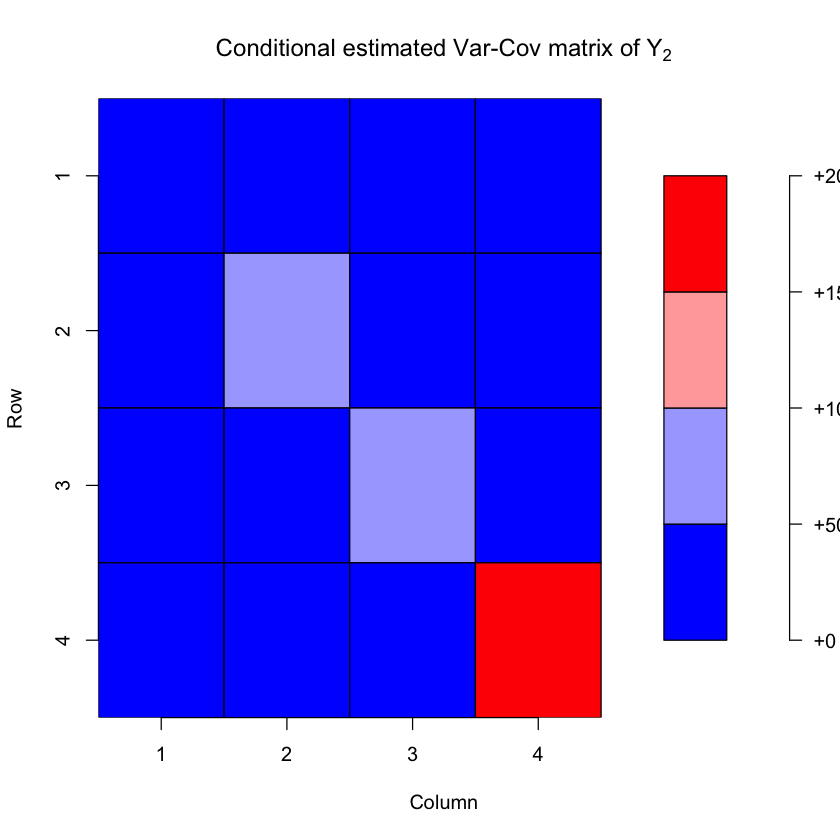

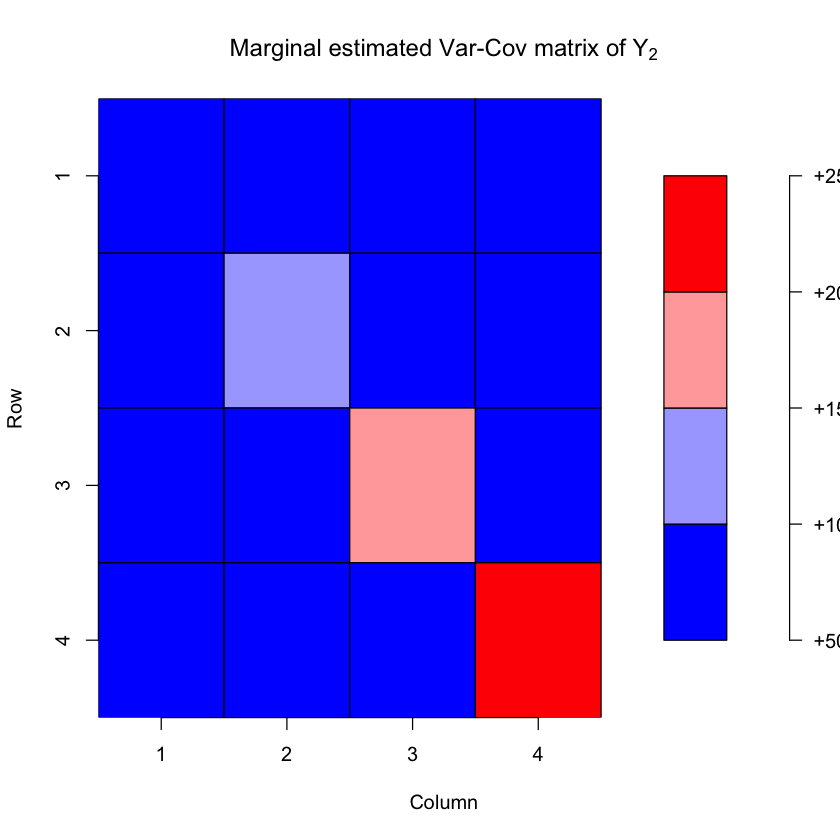

In [7]:
VarCorr(fm16.3)  

## var-cov matrix of the errors (i.e. of Y, conditional to the random effects), 
# that are independent but heteroscedastic 
# sigma^2 * R_i
fm16.3ccov = getVarCov(fm16.3, type = "conditional",  individual = "2")
fm16.3ccov
# example: sigma^2 * 4^(2*delta) = 3.60672^2 * 4^(2*0.3144) = 31.103

plot(as.matrix(fm16.3ccov[[1]]), 
     col=colorRampPalette(c("blue", "white", "red")),
     main = expression(paste('Conditional estimated Var-Cov matrix of ', Y[2])))

## var-cov matrix of Y_i
# sigma^2 * V_i
fm16.3cov = getVarCov(fm16.3, type = "marginal", individual = "2")
fm16.3cov # (90.479 = 31.103 + 59.37555; 121.440 = 62.062 + 59.37555; ...)
# The estimated variance of random intercepts sigma^2*d11 = 59.376. 
# --> It is smaller than the value of 80.608, obtained for model 16.1
# This is expected, because, by allowing for heteroscedastic
# residual random errors, a larger part of the total variability is explained by the
# residual variances.

# Corr(sigma^2 * V_i)
cov2cor(fm16.3cov[[1]])                    
# The corresponding estimated marginal correlation matrix indicates a decreasing
# correlation between visual acuity measurements made at more distant timepoints.

plot(as.matrix(fm16.3cov[[1]]), 
     col=colorRampPalette(c("blue", "white", "red")),
     main = expression(paste('Marginal estimated Var-Cov matrix of ', Y[2])))

# NB. Direct comparison of the marginal variance covariance
# matrices for models M12.3 and M16.2 is not appropriate. 
# --> marginal variance-covariance matrix of model M16.2, 
# is much more structured than that of model M12.3. 
# On the other hand, they both allow for marginal correlation coefficients, 
# which depend on the time “distances”, or “positions”, 
# of visual-acuity measurements.

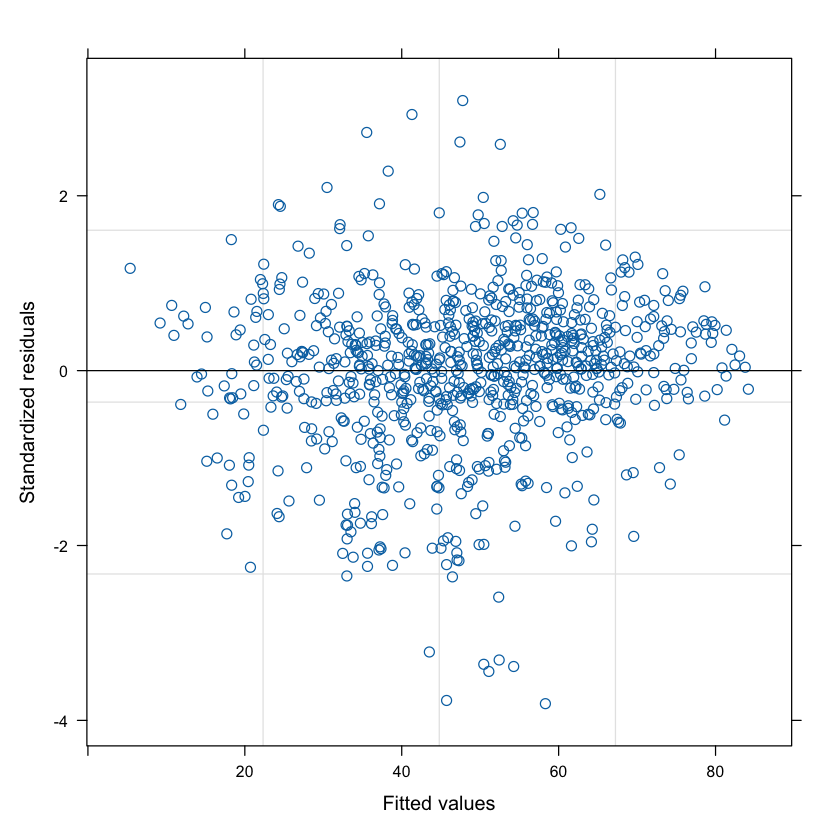

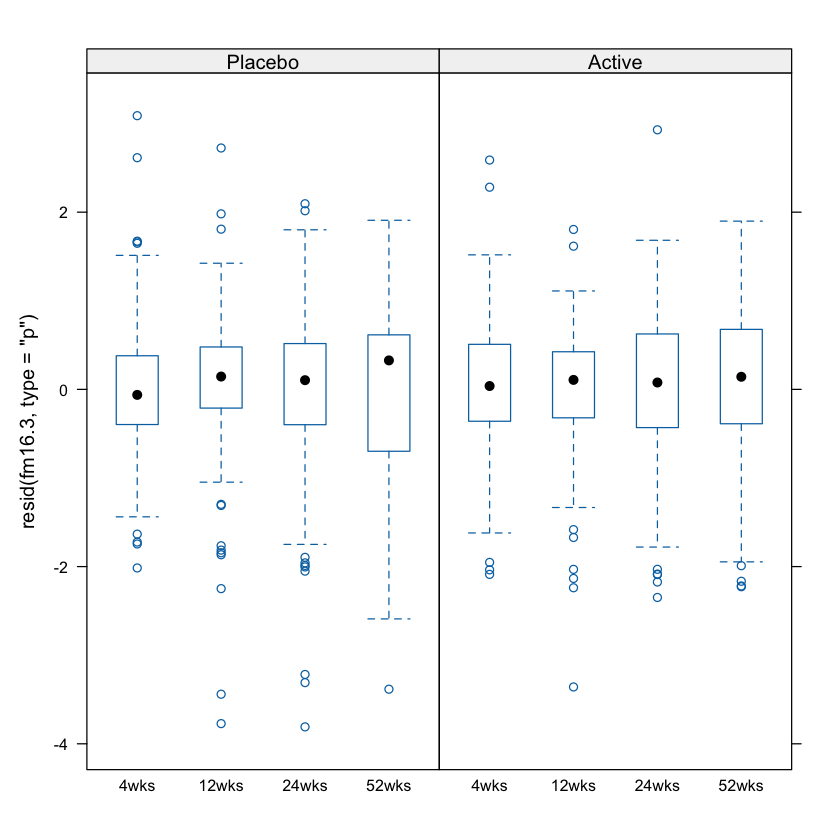

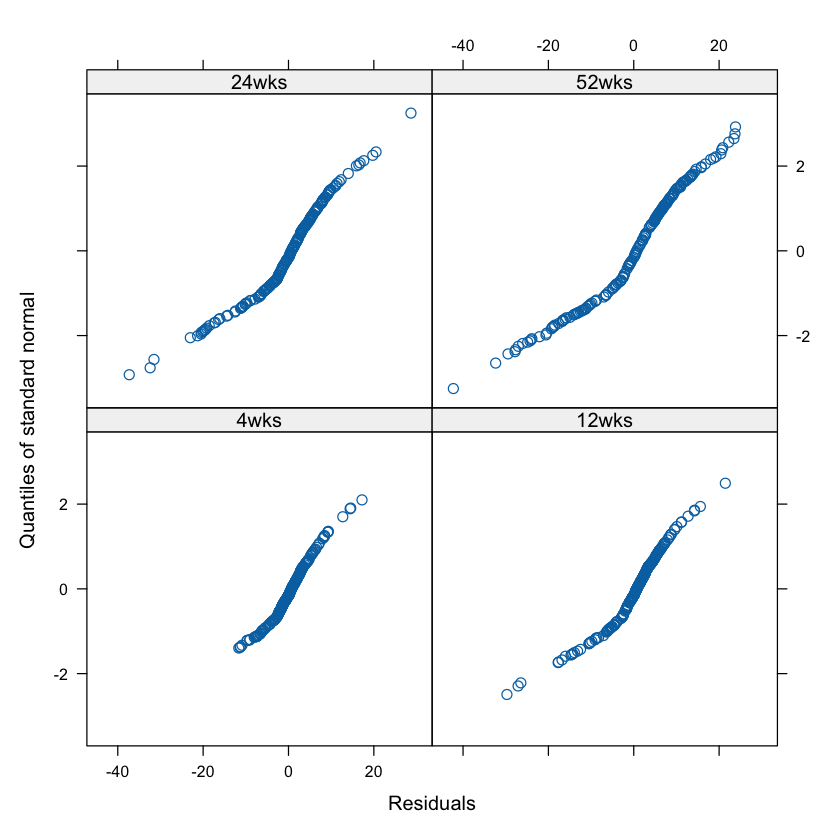

In [8]:
## ANALYSIS OF RESIDUALS

# Default residual plot of conditional Pearson residuals
plot(fm16.3)
# the plot is not very informative,
# because it pools all the residuals together, despite the fact that residuals 
# obtained from the same individual are potentially correlated. 
# However, it can serve for detecting, e.g., outliers.
# (at the bottom and the top of the central part of the scatterplot)


# Boxplots of Pearson residuals per time and treatment
bwplot(resid(fm16.3, type = "p") ~ time.f | treat.f, 
       data = armd)
# Despite standardization, the variability of the residuals seems to vary.
# The plot reveals also a number of outliers (in all treatment groups and at all timepoints)


# Normal Q-Q plots of Pearson residuals 
qqnorm(fm16.3, ~resid(.) | time.f) 

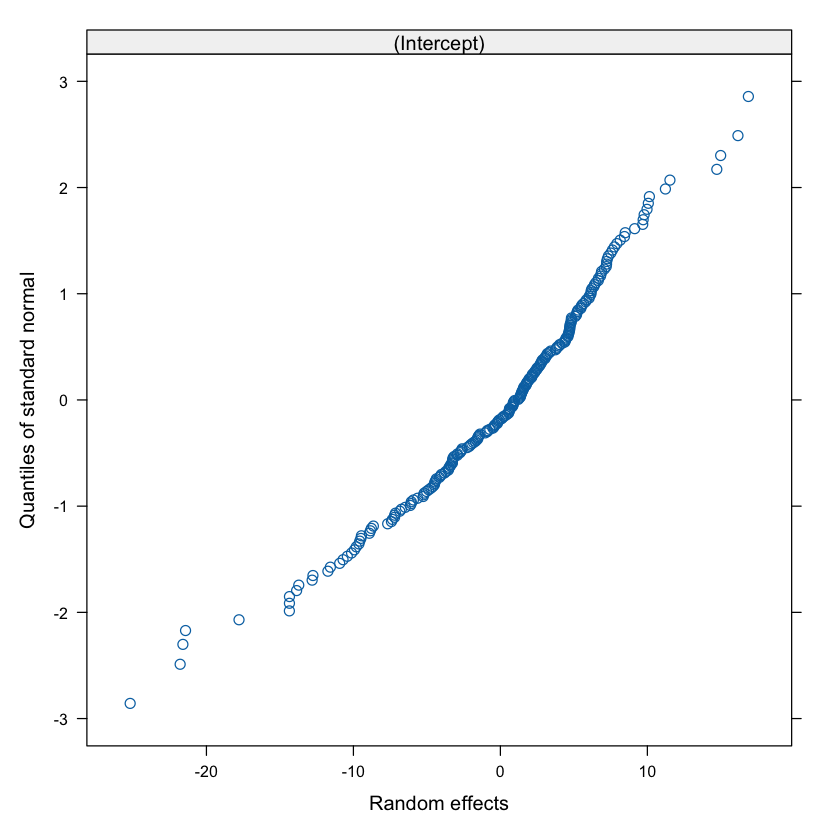

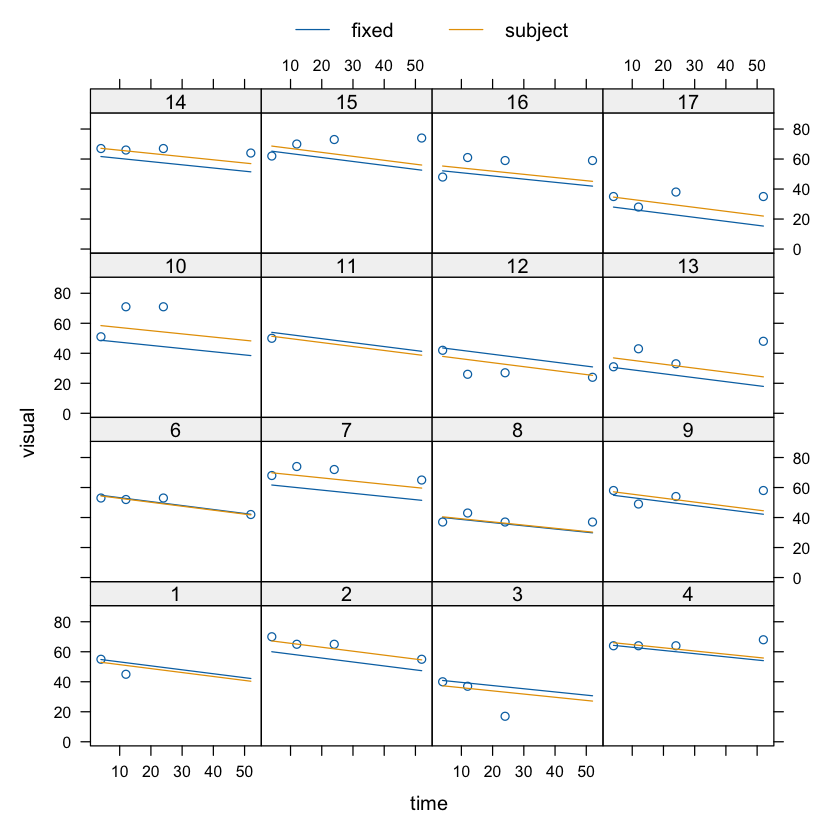

In [ ]:
## ANALYSIS OF RANDOM EFFECTS
# Normal Q-Q plots of predicted random effects
qqnorm(fm16.3, ~ranef(.))  
# NB observed distribution of bi^ does not necessary reflect the true distribution of bi 
# --> interpret with caution


## Computing predictions comparing population average predictions with patient-specific predictions
aug.Pred <- augPred(fm16.3,
                    primary = ~time, # Primary covariate
                    level = 0:1,     # fixed/marginal (0) and subj.-spec.(1)
                    length.out = 2)  # evaluated in two time instants (4 e 52 wks)

plot(aug.Pred, layout = c(4, 4, 1))
# The predicted population means decrease linearly in time.
# According to the assumed structure of the model, the population
# means are shifted for individual patients by subject-specific random intercepts.
# Slopes of the individual profiles are the same for all subjects.

# For example, for the subjects 4 and 15, the
# predicted individual patterns suggest a decrease of visual acuity over time, while the
# observed values actually increase over time.
# A possible way to improve the individual predictions is to allow not only for
# patient-specific random intercepts, but also for patient-specific random slopes.

In [10]:
#________________________________________________________________________________________________________________
#### Model 4.A. random intercept + slope (correlated), heteroscedastic residuals (varPower of time) (M16.4A) ####

fm16.4A <- update(fm16.3,
                 random = ~1 + time | subject,
                 data = armd)
summary(fm16.4A)

getVarCov(fm16.4A, individual = "2")  # sigma^2 * D_i (i=2)

intervals(fm16.4A, which = "var-cov")  # Estimates of sigma^2 * D, delta e sigma

# The results show a low estimated value
# of the correlation coefficient for the random effects b0i and b2i, equal to 0.138.
# The confidence interval for the correlation coefficient suggests that, in fact, the two
# random effects can be uncorrelated. 
# --> we consider a simplified form of the D matrix.

Linear mixed-effects model fit by REML
  Data: armd 
       AIC     BIC    logLik
  6450.598 6498.19 -3215.299

Random effects:
 Formula: ~1 + time | subject
 Structure: General positive-definite, Log-Cholesky parametrization
            StdDev    Corr  
(Intercept) 6.9789084 (Intr)
time        0.2722504 0.138 
Residual    5.1221953       

Variance function:
 Structure: Power of variance covariate
 Formula: ~time 
 Parameter estimates:
    power 
0.1074438 
Fixed effects:  list(lm2.form) 
                       Value Std.Error  DF   t-value p-value
(Intercept)         4.740327 2.2561568 631  2.101063  0.0360
visual0             0.909295 0.0381165 231 23.855712  0.0000
time               -0.215062 0.0322436 631 -6.669904  0.0000
treat.fActive      -2.260007 1.1497940 231 -1.965575  0.0505
time:treat.fActive -0.057468 0.0470409 631 -1.221653  0.2223
 Correlation: 
                   (Intr) visul0 time   trt.fA
visual0            -0.934                     
time               -0.071  0.0

Random effects variance covariance matrix
            (Intercept)    time
(Intercept)    48.70500 0.26266
time            0.26266 0.07412
  Standard Deviations: 6.9789 0.27225 

Approximate 95% confidence intervals

 Random Effects:
  Level: subject 
                           lower      est.     upper
sd((Intercept))        5.9956021 6.9789084 8.1234816
sd(time)               0.2302581 0.2722504 0.3219009
cor((Intercept),time) -0.1180552 0.1382424 0.3772719

 Variance function:
           lower      est.     upper
power 0.01782233 0.1074438 0.1970653

 Within-group standard error:
   lower     est.    upper 
4.031127 5.122195 6.508574 

Linear mixed-effects model fit by REML
  Data: armd 
       AIC      BIC    logLik
  6449.792 6492.625 -3215.896

Random effects:
 Formula: ~time | subject
 Structure: Diagonal
        (Intercept)      time Residual
StdDev:    7.231948 0.2809649 5.031159

Variance function:
 Structure: Power of variance covariate
 Formula: ~time 
 Parameter estimates:
    power 
0.1110751 
Fixed effects:  list(lm2.form) 
                       Value Std.Error  DF   t-value p-value
(Intercept)         5.262213 2.2658110 631  2.322441  0.0205
visual0             0.899900 0.0381957 231 23.560227  0.0000
time               -0.215031 0.0328493 631 -6.545989  0.0000
treat.fActive      -2.278756 1.1724506 231 -1.943584  0.0532
time:treat.fActive -0.056451 0.0479173 631 -1.178092  0.2392
 Correlation: 
                   (Intr) visul0 time   trt.fA
visual0            -0.932                     
time               -0.098  0.002              
treat.fActive      -0.278  0.026  0.185       
time:treat.fActive  0.0

Approximate 95% confidence intervals

 Fixed effects:
                        lower       est.       upper
(Intercept)         0.8127704  5.2622129  9.71165542
visual0             0.8246435  0.8999000  0.97515652
time               -0.2795380 -0.2150309 -0.15052381
treat.fActive      -4.5888197 -2.2787559  0.03130786
time:treat.fActive -0.1505476 -0.0564510  0.03764565

 Random Effects:
  Level: subject 
                    lower      est.     upper
sd((Intercept)) 6.3312808 7.2319476 8.2607401
sd(time)        0.2410987 0.2809649 0.3274231

 Variance function:
           lower      est.    upper
power 0.01765131 0.1110751 0.204499

 Within-group standard error:
   lower     est.    upper 
3.925353 5.031159 6.448479 

,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
fm16.4B,"lme.formula(fixed = lm2.form, data = armd, random = list(subject = pdDiag(~time)), weights = varPower(form = ~time))",1,9,6449.792,6492.625,-3215.896,,NA,NA
fm16.4A,"lme.formula(fixed = lm2.form, data = armd, random = ~1 + time | subject, weights = varPower(form = ~time))",2,10,6450.598,6498.190,-3215.299,1 vs 2,1.194014,0.2745213


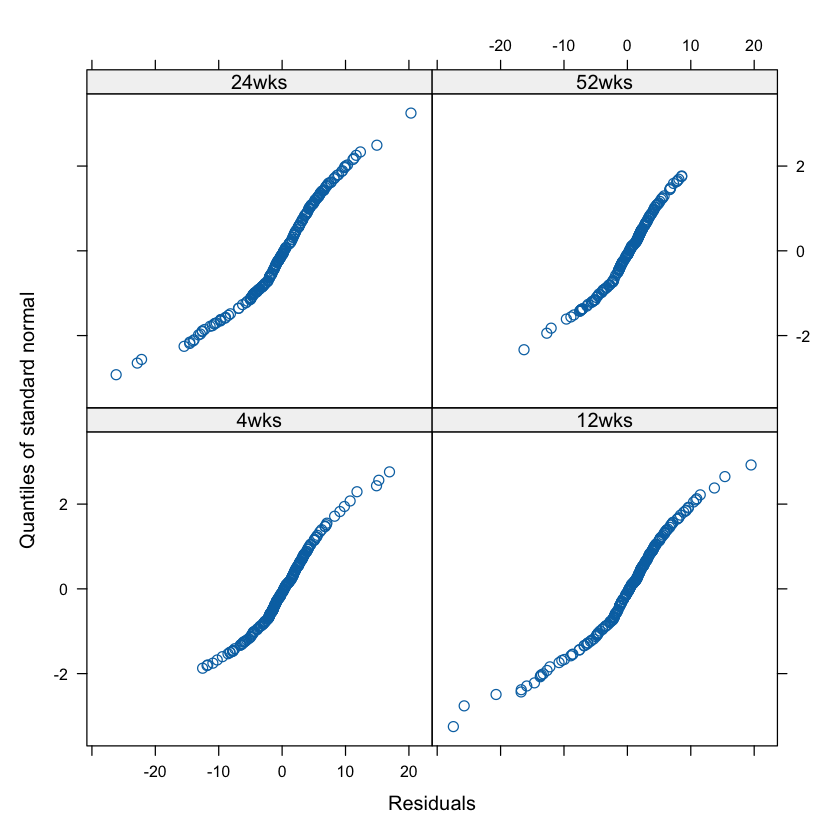

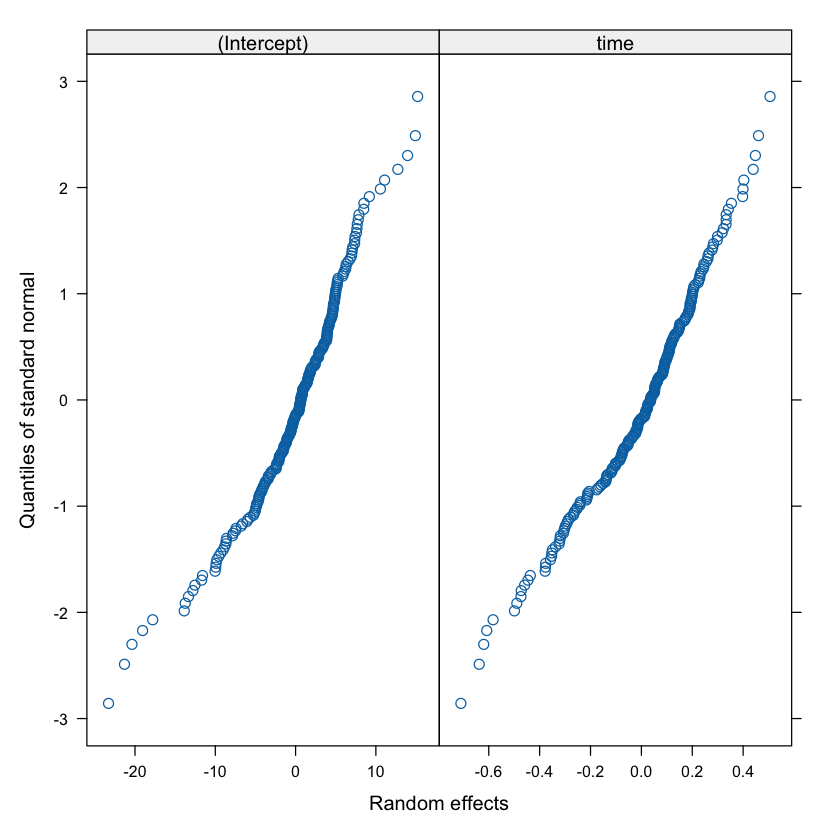

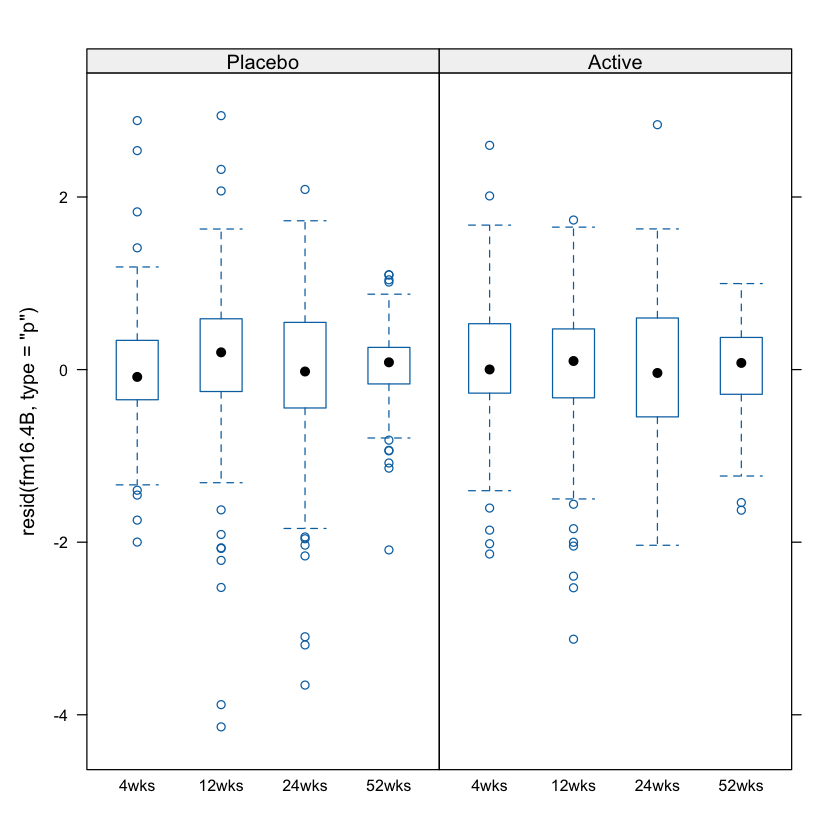

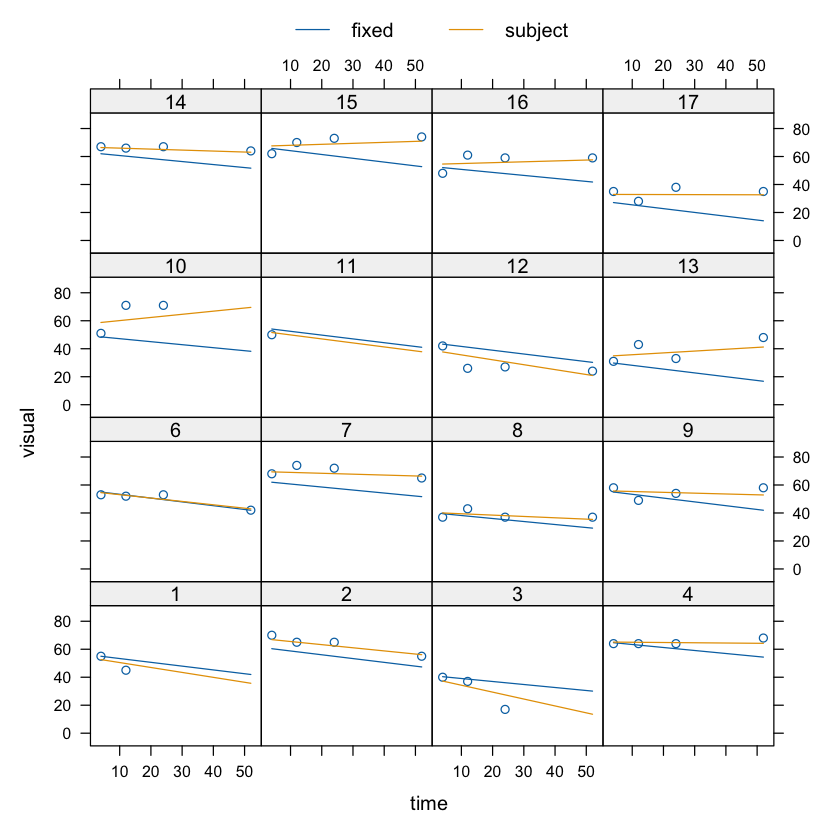

In [11]:
#______________________________________________________________________________________________________#
## Model 4.B. random intercept + slope independent, heteroscedastic residuals (varPower of time) (M16.4B)
fm16.4B <- update(fm16.4A,
                 random = list(subject = pdDiag(~time)), # Diagonal D
                 data = armd) 
summary(fm16.4B) ## results suggest to remove the Treat and Time interaction

intervals(fm16.4B)
# delta = 0.11 --> marginal variance function is quadratic over time
# the var(Yit) function increases with time (since d11, d22 and sigma^2 are positive)


anova(fm16.4B, fm16.4A)  # H0: d_12=0
# We test if d_12 = 0 --> not statistically significant at 5%, we can simplify the D structure in diagonal


## ANALYSIS OF RESIDUALS
qqnorm(fm16.4B, ~resid(.) | time.f) 

## ANALYSIS OF RANDOM EFFECTS
qqnorm(fm16.4B, ~ranef(.)) 
# to be interpreted with caution since it might not reflect the real unknown distribution

bwplot(resid(fm16.4B, type = "p") ~ time.f | treat.f, 
       panel = panel.bwplot, # User-defined panel (not shown)
       data = armd)

## We make predictions comparing population average predictions with patient specific predictions
aug.Pred <- augPred(fm16.4B,
                    primary = ~time, # Primary covariate
                    level = 0:1,     # Marginal(0) and subj.-spec.(1)
                    length.out = 2)  # Evaluated in two time instants (4 e 52 wks)
plot(aug.Pred, layout = c(4, 4, 1), columns = 2) 
# slopes vary. -->  the predicted individual profiles follow more closely 
# the observed values and capture, e.g., increasing trends in time,
# --> better fit than before

In [12]:

## let's compare the 4 fitted models 
AIC(fm16.1,fm16.3,fm16.4A, fm16.4B)
anova(fm16.1,fm16.3,fm16.4A, fm16.4B)

,df,AIC
,<dbl>,<dbl>
fm16.1,7,6591.971
fm16.3,8,6537.126
fm16.4A,10,6450.598
fm16.4B,9,6449.792


,call,Model,df,AIC,BIC,logLik,Test,L.Ratio,p-value
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
fm16.1,"lme.formula(fixed = lm2.form, data = armd, random = ~1 | subject)",1,7,6591.971,6625.286,-3288.986,,NA,NA
fm16.3,"lme.formula(fixed = lm2.form, data = armd, random = ~1 | subject, weights = varPower(form = ~time))",2,8,6537.126,6575.200,-3260.563,1 vs 2,56.845309,4.714774e-14
fm16.4A,"lme.formula(fixed = lm2.form, data = armd, random = ~1 + time | subject, weights = varPower(form = ~time))",3,10,6450.598,6498.190,-3215.299,2 vs 3,90.528238,2.198077e-20
fm16.4B,"lme.formula(fixed = lm2.form, data = armd, random = list(subject = pdDiag(~time)), weights = varPower(form = ~time))",4,9,6449.792,6492.625,-3215.896,3 vs 4,1.194014,2.745213e-01
